### GradCAM
https://keras.io/examples/vision/grad_cam/<br>
https://github.com/samson6460/tf_keras_gradcamplusplus

### Issue if using cusmtom model (rather than Sequential model)
1. AttributeError: Layer ___ has no inbound nodes.
add build to the model
```
    def build(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape[1:], name="input_x")
        self.call(x)
```
2. Change all of these<br>
  <b>2.1</b> model.inputs => model.layers[0].input <br>
  <b>2.2</b> model.get_layer(last_conv_layer_name).output => model.get_layer(last_conv_layer_name).input "this is for the resenet that using GAP (global average pooling) that is so just get the layer before GAP"<br>
  <b>2.3</b> model.output => model.layers[-1].output<br>

So all change this line to:
```
    grad_model = tf.keras.models.Model(
        [model.layers[0].input], [model.get_layer(last_conv_layer_name).input, model.layers[-1].output]
    )
```
3. If load model, need to call model once "model(input)"

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

In [5]:
init_lr = 1e-3
batch_size = 64

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)
x_train, x_test = x_train / 255.0, x_test / 255.0
print('raw x_train:', x_train.shape)

# # Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
print('train_ds:', train_ds._input_dataset)
print('x_train:', x_train.mean(), x_train.max(), x_train.min())

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2, name="maxPool2"))
model.add(Flatten())
model.add(Dense(10, activation=None))

def get_cross_entropy_loss(labels, logits):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels,
                                                   logits=logits)
    return tf.reduce_mean(loss)

@tf.function
def test_step(images, labels):
    logits = model(images, training=False)
    test_acc(tf.nn.softmax(logits), labels)

@tf.function
def train_step(src_images, src_labels):
    with tf.GradientTape() as tape:
        src_logits = model(src_images, training=True)
        batch_cross_entropy_loss = get_cross_entropy_loss(labels=src_labels,
                                                          logits=src_logits)

    gradients = tape.gradient(batch_cross_entropy_loss,
                              model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    source_train_acc(src_labels, tf.nn.softmax(src_logits))


learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    init_lr,
    decay_steps=(x_train.shape[0] // batch_size) * 2,
    end_learning_rate=init_lr * 1e-2,
    cycle=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
test_acc = tf.keras.metrics.CategoricalAccuracy()
source_train_acc = tf.keras.metrics.CategoricalAccuracy()

for epoch in range(1):
    for images, labels in train_ds:
        train_step(images, labels)
    for images, labels in test_ds:
        test_step(images, labels)
    print('epoch:',epoch, 'train:', source_train_acc.result().numpy(), 'test:', test_acc.result().numpy())

raw x_train: (60000, 28, 28)
train_ds: <ShuffleDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>
x_train: 0.13066062 1.0 0.0
epoch: 0 train: 0.9479 test: 0.9849


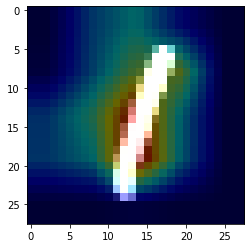

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_imgwithheat(heatmap, img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    img = (img*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    imgwithheat = Image.fromarray(superimposed_img)  
    plt.imshow(imgwithheat)
    
idx = 5
img = next(iter(test_ds))[0][idx:idx+1]
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="maxPool2")
show_imgwithheat(heatmap, img[0].numpy())

### CAM [Class Activation maps] 
https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923 <br>
https://github.com/chaeyoung-lee/pytorch-CAM

# THIS DOESN'T WORK YET

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2304, 10)
        self.is_CAM=False

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        if self.is_CAM:
            return x
        
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target) # nn.CrossEntropyLoss applies internally F.log_softmax and nn.NLLLoss
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../../../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../../../data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    scheduler.step()

# if args.save_model:
#     torch.save(model.state_dict(), "mnist_cnn.pt")

/home/epinyoan/git/exit-research/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312105
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.085922
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.210373
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.184049
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.132320
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.026202
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.106469
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.055337
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.068782
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.124652

Test set: Average loss: 0.0497, Accuracy: 9838/10000 (98%)



In [5]:
# a=torch.tensor([[1.,2.,3.],[4.,5.,6.]])
# a.mean(dim=0)
# a.view(2, -1)
x = torch.rand((64,12,12))
x = x.view(x.shape[0], -1)
x = x.mean(1)


In [10]:
class CAMLayer(nn.Module):
    def __init__(self, c=3):
        super().__init__() 
        self.fc=nn.Linear(16,10)

    def forward(self,x):     
        # 16,12,12=2304
#         x = torch.flatten(x, 1)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = x.mean(dim=2)
        x=self.fc(x)
        return  F.softmax(x,dim=1)
model.is_CAM = True
CAM_layer = CAMLayer()
CAM_model=nn.Sequential(model, CAM_layer).to(device)

trainable_parameters = []
for name, p in CAM_model.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)
optimizer = torch.optim.SGD(params=trainable_parameters, lr=100, momentum=1e-5)  
for epoch in range(1):
    train(CAM_model, train_loader, optimizer, epoch)
    test(CAM_model, test_loader)


x: torch.Size([64, 16, 12, 12])
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300181
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 12])
x: torch.Size([64, 16, 12, 

KeyboardInterrupt: 

In [ ]:
list(CAM_layer.parameters())

In [ ]:
list(CAM_layer.parameters())[0].data.cpu().numpy().shape

### TODO
- working on dim of w of conv to last linear layer
- prediction cls needs to be sorted
- dot or matmul

In [ ]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (28, 28)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        print('weight[idx]:', weight[idx].shape, 'feature_conv:', feature_conv.shape)
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.dot(weight[idx], beforeDot)
        print(cam.shape) # TODOOOOOOOOOOOOOOOO This should be sum
        cam = cam.reshape(h, w) 
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
data, cls = next(iter(test_loader))
sample_image = data[:1].to(device)
sample_cls = cls[:1].to(device)
feature_conv = model(sample_image).data.cpu().numpy()
weight = list(CAM_layer.parameters())[0].data.cpu().numpy()
return_CAM(feature_conv, weight, sample_cls)

In [ ]:
plt.imshow(sample_image[0].cpu().detach().squeeze().numpy())